# Introduction

This notebook will be used only to analyze data from the SciPy execution of Leaflet Finder. The experiment setup is as follows:

1. Execution was done on Comet.
2. The core count was 64,256,1024 cores
3. One CU/task per core
4. The calculation was done over 131072 atoms and the whole matrix was calculated.
5. The produced matrix was aggregated to a single Unit to calculate the connected components.

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))

In [3]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [4]:
def SparkLogToDataFrame(path,filename):
    import json
    import pandas
    import numpy as np

    columns=['StageID','TaskId','ExecutorID','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','GettingResultTime','ResultSerializationTime','FinishTime','ResultSize']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

      
        
        
    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((1,11),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0,0] = int(stat['Stage ID'])
            data_point[0,1] = int(stat['Task Info']['Task ID'])
            data_point[0,2] = int(stat['Task Info']['Executor ID'])
            data_point[0,3] = int(stat['Task Info']['Launch Time'])
            data_point[0,5] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[0,6] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[0,7] = int(stat['Task Info']['Finish Time'])-int(stat['Task Info']['Getting Result Time']) if int(stat['Task Info']['Getting Result Time'])!=0 else 0 
            data_point[0,8] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[0,9] = int(stat['Task Info']['Finish Time'])
            data_point[0,10] = int(stat['Task Metrics']['Result Size'])
            
            data_point[0,4]= data_point[0,9]-data_point[0,3]-data_point[0,5]-data_point[0,6]-data_point[0,8]-data_point[0,7]
            data_case = pandas.DataFrame(data_point,columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


In [5]:
def SparkSessionToDataFrame(sessionName,path,appName):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize','ReadTime','Exec']
    data=pandas.DataFrame(np.zeros((1,10)),columns=columns,dtype=np.int64)
    data_point = np.zeros((10,1),dtype=np.int64)
    
    if appName != 'miss':
        appPath = path + sessionName + '/' + appName
        print appPath
        timings = np.load(path + sessionName + '/timing.npz.npy')

        stat_file=open(appPath)
        stats=list();
        for line in stat_file:
            stats.append(json.loads(line))

        for stat in stats:
            if stat['Event'] == 'SparkListenerTaskEnd':
                data_point[0] = int(stat['Task Info']['Task ID'])
                data_point[1] = int(stat['Task Info']['Launch Time'])
                data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
                data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
                data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
                data_point[6] = int(stat['Task Info']['Finish Time'])
                data_point[7] = int(stat['Task Metrics']['Result Size'])
                data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
                data_point[8] = timings[data_point[0],1]-timings[data_point[0],0]
                data_point[9] = timings[data_point[0],2]-timings[data_point[0],1]
                data_case = pandas.DataFrame(data_point.reshape((1,10)),columns=columns)
                data = data.append(data_case,ignore_index=True)
            
    return data

In [6]:
def SessionToPandas(path,sessionName,cores):
    
    unit_path = path+sessionName+'/'
    
    sessionDataFrame = pandas.DataFrame(columns=['Read','Exec','Write'],dtype=np.float)
    for i in range(0,cores):
        data_point = np.zeros((1,3),dtype=np.float)
        stdoutFile = open(unit_path + 'unit.%06i'%i+'/STDOUT')
        for line in stdoutFile:
            if line.startswith('Data Read:'):
                lineList=line.split()
                data_point[0,0] = np.float(lineList[2])
                data_point[0,1] = np.float(lineList[5])
            elif line.startswith('Total Time'):
                lineList = line.split()
                data_point[0,2] = np.float(lineList[6]) - data_point[0,0] - data_point[0,1]
            
        sessionDataFrame = sessionDataFrame.append(pandas.DataFrame((data_point),columns=['Read','Exec','Write']),ignore_index=True)
            
    return sessionDataFrame

# 1. Broadcast Experiments

## 1.1 Setting up everything

In [13]:
spBroad = pandas.DataFrame.from_csv('Spark/BroadCast/comet_execution.csv')
spBroad


,Cores,Try,Atoms,Partition,RP-Overhead,Spark-Overhead,AdjMatrix,ConnComp,Write,Execution,SessionName,JsonName
Index,,,,,,,,,,,,
0,64,1,131072,2048,6.786175,2.090282,189.591191,45.350601,0.009627,246.833125,spBroad_lf_2048_64_1,app-20170302043215-0000
1,64,2,131072,2048,6.509579,1.957083,181.923787,46.712931,0.013566,242.434149,spBroad_lf_2048_64_2,app-20170302175306-0000
2,64,3,131072,2048,5.481148,1.953701,193.578272,46.908706,0.011650,250.783590,spBroad_lf_2048_64_3,app-20170302233907-0000
3,256,1,131072,512,5.647347,1.933108,68.626587,45.020126,0.017884,124.885591,spBroad_lf_512_256_1,app-20170303113011-0000
4,256,2,131072,512,11.391606,1.959127,76.339587,47.115182,0.010774,139.795884,spBroad_lf_512_256_2,app-20170303142736-0000
5,256,3,131072,512,5.437252,1.907767,71.830182,47.060999,0.012910,129.105872,spBroad_lf_512_256_3,app-20170303144319-0000
6,1024,1,131072,128,7.618607,2.035006,50.243952,46.155568,0.014462,109.169327,spBroad_lf_128_1024_1,app-20170304112729-0000
7,1024,2,131072,128,11.387159,2.044974,50.463118,46.885230,0.013259,114.046710,spBroad_lf_128_1024_2,app-20170304123058-0000
8,1024,3,131072,128,5.827979,1.972116,52.755637,46.754664,0.011023,110.591033,spBroad_lf_128_1024_3,app-20170304123413-0000


In [81]:
tidy_broadcast = pandas.melt(spBroad.drop(['SessionName','JsonName'],axis=1),id_vars=['Cores','Try','Atoms','Partition'],var_name='Type', value_name='Time(s)')
tidy_broadcast['Scenario']='Broadcast'
tidy_broadcast

,Cores,Try,Atoms,Partition,Type,Time(s),Scenario
0,64,1,131072,2048,RP-Overhead,6.786175,Broadcast
1,64,2,131072,2048,RP-Overhead,6.509579,Broadcast
2,64,3,131072,2048,RP-Overhead,5.481148,Broadcast
3,256,1,131072,512,RP-Overhead,5.647347,Broadcast
4,256,2,131072,512,RP-Overhead,11.391606,Broadcast
5,256,3,131072,512,RP-Overhead,5.437252,Broadcast
6,1024,1,131072,128,RP-Overhead,7.618607,Broadcast
7,1024,2,131072,128,RP-Overhead,11.387159,Broadcast
8,1024,3,131072,128,RP-Overhead,5.827979,Broadcast
9,64,1,131072,2048,Spark-Overhead,2.090282,Broadcast


In [14]:
spBroad_app_64_1   = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][0]+'/unit.000000/',spBroad['JsonName'][0])
spBroad_app_64_2   = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][1]+'/unit.000000/',spBroad['JsonName'][1])
spBroad_app_64_3   = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][2]+'/unit.000000/',spBroad['JsonName'][2])
spBroad_app_256_1  = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][3]+'/unit.000000/',spBroad['JsonName'][3])
spBroad_app_256_2  = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][4]+'/unit.000000/',spBroad['JsonName'][4])
spBroad_app_256_3  = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][5]+'/unit.000000/',spBroad['JsonName'][5])
spBroad_app_1024_1 = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][6]+'/unit.000000/',spBroad['JsonName'][6])
spBroad_app_1024_2 = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][7]+'/unit.000000/',spBroad['JsonName'][7])
spBroad_app_1024_3 = SparkLogToDataFrame('Spark/AppData/spBroad_lf/'+spBroad['SessionName'][8]+'/unit.000000/',spBroad['JsonName'][8])


In [116]:
spBroad_app_1024_1['ExecutorID']

42.0    24
11.0    24
19.0    24
18.0    24
17.0    24
16.0    24
15.0    24
14.0    24
13.0    24
12.0    24
10.0    24
41.0    24
9.0     24
8.0     24
7.0     24
6.0     24
5.0     24
4.0     24
2.0     24
1.0     24
20.0    24
21.0    24
22.0    24
23.0    24
40.0    24
39.0    24
38.0    24
37.0    24
36.0    24
35.0    24
34.0    24
33.0    24
32.0    24
31.0    24
30.0    24
29.0    24
28.0    24
27.0    24
26.0    24
25.0    24
24.0    24
0.0     24
3.0     16
Name: ExecutorID, dtype: int64

# 2. Serial Read RDD experiments

## 2.1. Setup everything

In [18]:
spsc_lf = pandas.DataFrame.from_csv('Spark/ScipyDist/reports_comet_6_3_2017.csv')
spsc_lf

,Cores,Try,RP-Overhead,Spark-Overhead,AdjMatrix,ConnComp,Write,Execution,SessionName,JsonName
Index,,,,,,,,,,
0,64,1,5.822892,1.911833,170.428758,45.805061,0.009793,221.058158,spcolfsci_64_4,app-20170226185001-0000
1,64,2,5.513493,2.429640,164.631126,45.010785,0.009485,214.966357,spcolfsci_64_5,app-20170226193645-0000
2,64,3,5.897666,2.391985,173.656738,45.922570,0.010422,224.935990,spcolfsci_64_6,app-20170226194830-0000
3,256,1,5.856283,1.885603,71.971010,45.452681,0.013648,122.175673,spcolfsci_256_4,app-20170226205654-0000
4,256,2,7.688435,2.643788,68.473908,46.736236,0.011356,121.239088,spcolfsci_256_5,app-20170226201334-0000
5,256,3,5.662983,2.854392,71.926385,46.936766,0.010444,124.736171,spcolfsci_256_6,app-20170226212345-0000
6,1024,1,5.481153,5.130594,49.742698,46.332103,0.013429,104.291068,spcolfsci_1024_7,app-20170227073358-0000
7,1024,2,5.788779,5.390297,47.346035,46.827443,0.010228,104.291068,spcolfsci_1024_8,app-20170227082642-0000
8,1024,3,5.491972,4.671294,49.619576,45.349574,0.016988,102.783497,spcolfsci_1024_9,app-20170227102203-0000


In [84]:
tidy_spsc=pandas.melt(spsc_lf.drop(['SessionName','JsonName'],axis=1),id_vars=['Cores','Try'], var_name='Type', value_name='Time(s)')
tidy_spsc['Scenario']='RDD'
tidy_spsc['Partition']='N/A'
tidy_spsc['Atoms']=131072
tidy_spsc

,Cores,Try,Type,Time(s),Scenario,Partition,Atoms
0,64,1,RP-Overhead,5.822892,RDD,N/A,131072
1,64,2,RP-Overhead,5.513493,RDD,N/A,131072
2,64,3,RP-Overhead,5.897666,RDD,N/A,131072
3,256,1,RP-Overhead,5.856283,RDD,N/A,131072
4,256,2,RP-Overhead,7.688435,RDD,N/A,131072
5,256,3,RP-Overhead,5.662983,RDD,N/A,131072
6,1024,1,RP-Overhead,5.481153,RDD,N/A,131072
7,1024,2,RP-Overhead,5.788779,RDD,N/A,131072
8,1024,3,RP-Overhead,5.491972,RDD,N/A,131072
9,64,1,Spark-Overhead,1.911833,RDD,N/A,131072


In [19]:
spsc_lf_app_64_1 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][0]+'/unit.000000/',spsc_lf['JsonName'][0])
spsc_lf_app_64_2 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][1]+'/unit.000000/',spsc_lf['JsonName'][1])
spsc_lf_app_64_3 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][2]+'/unit.000000/',spsc_lf['JsonName'][2])
spsc_lf_app_256_1 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][3]+'/unit.000000/',spsc_lf['JsonName'][3])
spsc_lf_app_256_2 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][4]+'/unit.000000/',spsc_lf['JsonName'][4])
spsc_lf_app_256_3 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][5]+'/unit.000000/',spsc_lf['JsonName'][5])
spsc_lf_app_1024_1 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][6]+'/unit.000000/',spsc_lf['JsonName'][6])
spsc_lf_app_1024_2 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][7]+'/unit.000000/',spsc_lf['JsonName'][7])
spsc_lf_app_1024_3 = SparkLogToDataFrame('Spark/AppData/atoms131072/ScipyDist/'+spsc_lf['SessionName'][8]+'/unit.000000/',spsc_lf['JsonName'][8])


In [20]:
spsc_lf_app_64_1

,StageID,TaskId,ExecutorID,LaunchTime,SchedulerDelay,DeserializeTime,Runtime,GettingResultTime,ResultSerializationTime,FinishTime,ResultSize
0,0.0,54.0,0.0,1.488164e+12,993.0,392.0,3848.0,5649.0,417.0,1.488164e+12,269747345.0
1,0.0,49.0,0.0,1.488164e+12,1204.0,405.0,3787.0,6788.0,458.0,1.488164e+12,269747343.0
2,0.0,53.0,0.0,1.488164e+12,1183.0,394.0,3840.0,8214.0,434.0,1.488164e+12,269747345.0
3,0.0,55.0,0.0,1.488164e+12,1196.0,392.0,3837.0,9644.0,425.0,1.488164e+12,269747345.0
4,0.0,63.0,0.0,1.488164e+12,6742.0,384.0,3809.0,8673.0,468.0,1.488164e+12,269747345.0
5,0.0,62.0,0.0,1.488164e+12,8048.0,386.0,3881.0,8678.0,422.0,1.488164e+12,269747345.0
6,0.0,57.0,0.0,1.488164e+12,9469.0,390.0,3828.0,8692.0,484.0,1.488164e+12,269747343.0
7,0.0,56.0,0.0,1.488164e+12,10850.0,391.0,3916.0,11857.0,452.0,1.488164e+12,269747342.0
8,0.0,50.0,0.0,1.488164e+12,15453.0,399.0,3906.0,8328.0,445.0,1.488164e+12,269747343.0
9,0.0,59.0,0.0,1.488164e+12,16884.0,388.0,3793.0,8394.0,467.0,1.488164e+12,269747343.0


# 3. Parallel CC

## 3.1. Setting up Everything

In [22]:
spParCC_lf = pandas.DataFrame.from_csv('Spark/Scipy-par-CC/reports_comet_20_2_2017.csv')
spParCC_lf

,Cores,Try,Atoms,Partition,Overhead,Execution,SessionName,JsonName
Index,,,,,,,,
0,64,1,131072,16384,5.451380,72.433422,spParCC_131K_16384_64_1,app-20170220090857-0000
1,64,2,131072,16384,5.726651,72.528572,spParCC_131K_16384_64_2,app-20170220091550-0000
2,64,3,131072,16384,6.751546,77.309438,spParCC_131K_16384_64_3,app-20170220093951-0000
3,256,1,131072,8192,5.684547,24.869305,spParCC_131K_8192_256_1,app-20170220102611-0000
4,256,2,131072,8192,5.855266,26.056547,spParCC_131K_8192_256_2,app-20170220111227-0000
5,256,3,131072,8192,10.567204,25.519617,spParCC_131K_8192_256_3,app-20170220112818-0000
6,1024,1,131072,4096,5.441179,21.526379,spParCC_131K_4096_1024_1,app-20170220114148-0000
7,1024,2,131072,4096,5.736078,20.227811,spParCC_131K_4096_1024_2,app-20170220114817-0000
8,1024,3,131072,4096,5.682187,21.864113,spParCC_131K_4096_1024_3,app-20170220160605-0000


In [90]:
tidy_spParCC_lf=pandas.melt(spParCC_lf.drop(['SessionName','JsonName'],axis=1),id_vars=['Cores','Try','Atoms','Partition'],var_name='Type', value_name='Time(s)')
tidy_spParCC_lf['Scenario']='ParallelCC'


Index([u'Cores', u'Try', u'Atoms', u'Partition', u'Type', u'Time(s)',
       u'Scenario'],
      dtype='object')

In [98]:
print tidy_spParCC_lf.columns
print tidy_broadcast.columns
print tidy_spsc.columns

tidy = tidy_spsc.append(tidy_broadcast, ignore_index=True)
tidy2 = tidy.append(tidy_spParCC_lf,ignore_index=True)
tidy2.to_csv('broadcastVSrddVsParallelCC.csv')

Index([u'Cores', u'Try', u'Atoms', u'Partition', u'Type', u'Time(s)',
       u'Scenario'],
      dtype='object')
Index([u'Cores', u'Try', u'Atoms', u'Partition', u'Type', u'Time(s)',
       u'Scenario'],
      dtype='object')
Index([u'Cores', u'Try', u'Type', u'Time(s)', u'Scenario', u'Partition',
       u'Atoms'],
      dtype='object')


In [23]:
spParCC_lf_ParCC_app_64_1 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][0]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][0])
spParCC_lf_ParCC_app_64_2 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][1]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][1])
spParCC_lf_ParCC_app_64_3 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][2]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][2])
spParCC_lf_ParCC_app_256_1 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][3]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][3])
spParCC_lf_ParCC_app_256_2 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][4]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][4])
spParCC_lf_ParCC_app_256_3 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][5]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][5])
spParCC_lf_ParCC_app_1024_1 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][6]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][6])
spParCC_lf_ParCC_app_1024_2 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][7]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][7])
spParCC_lf_ParCC_app_1024_3 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][8]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][8])

In [24]:
spParCC_lf_ParCC_app_64_1

,StageID,TaskId,ExecutorID,LaunchTime,SchedulerDelay,DeserializeTime,Runtime,GettingResultTime,ResultSerializationTime,FinishTime,ResultSize
0,0.0,56.0,0.0,1.487611e+12,143.0,365.0,60043.0,0.0,0.0,1.487611e+12,969.0
1,0.0,59.0,0.0,1.487611e+12,134.0,362.0,60087.0,0.0,0.0,1.487611e+12,969.0
2,0.0,60.0,0.0,1.487611e+12,134.0,362.0,60091.0,0.0,1.0,1.487611e+12,2106.0
3,0.0,51.0,0.0,1.487611e+12,132.0,371.0,60097.0,0.0,0.0,1.487611e+12,969.0
4,0.0,48.0,0.0,1.487611e+12,133.0,374.0,60109.0,0.0,0.0,1.487611e+12,969.0
5,0.0,58.0,0.0,1.487611e+12,132.0,363.0,60134.0,0.0,0.0,1.487611e+12,969.0
6,0.0,57.0,0.0,1.487611e+12,134.0,364.0,60136.0,0.0,0.0,1.487611e+12,969.0
7,0.0,49.0,0.0,1.487611e+12,132.0,374.0,60147.0,0.0,0.0,1.487611e+12,969.0
8,0.0,53.0,0.0,1.487611e+12,134.0,368.0,60187.0,0.0,0.0,1.487611e+12,3806.0
9,0.0,52.0,0.0,1.487611e+12,132.0,374.0,60190.0,0.0,0.0,1.487611e+12,969.0


# Plotting

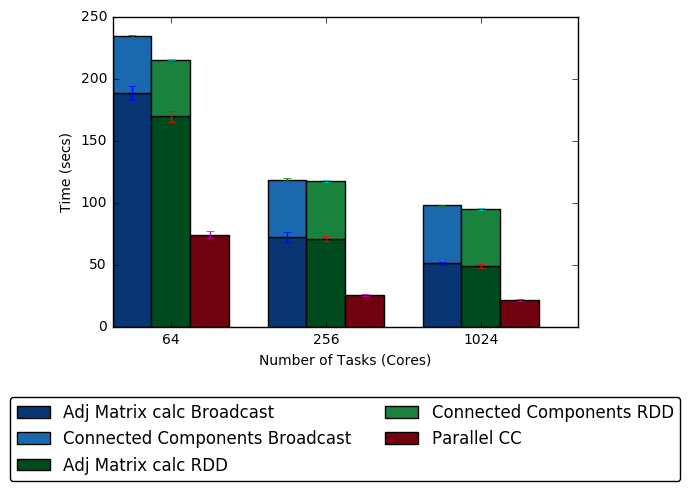

In [104]:
width =0.25
elements = np.arange(3)
fig,axes=plt.subplots(ncols=1,nrows=1)
plt.bar(elements,[spBroad['AdjMatrix'][0:3].mean(),\
                  spBroad['AdjMatrix'][3:6].mean(),\
                  spBroad['AdjMatrix'][6:9].mean()],width=width,
       yerr=[spBroad['AdjMatrix'][0:3].std(),\
             spBroad['AdjMatrix'][3:6].std(),\
             spBroad['AdjMatrix'][6:9].std()],color=[blues(250),blues(250),blues(250)],label='Adj Matrix calc Broadcast')
plt.bar(elements,[spBroad['ConnComp'][0:3].mean(),\
                  spBroad['ConnComp'][3:6].mean(),\
                  spBroad['ConnComp'][6:9].mean()],width=width,
       yerr=[spBroad['ConnComp'][0:3].std(),\
             spBroad['ConnComp'][3:6].std(),\
             spBroad['ConnComp'][6:9].std()],
       bottom=[spBroad['AdjMatrix'][0:3].mean(),\
               spBroad['AdjMatrix'][3:6].mean(),\
               spBroad['AdjMatrix'][6:9].mean()],color=[blues(200),blues(200),blues(200)],label='Connected Components Broadcast')

plt.bar(elements+width,[spsc_lf['AdjMatrix'][0:3].mean(),\
                        spsc_lf['AdjMatrix'][3:6].mean(),\
                        spsc_lf['AdjMatrix'][6:9].mean()],width=width,
       yerr=[spsc_lf['AdjMatrix'][0:3].std(),\
             spsc_lf['AdjMatrix'][3:6].std(),\
             spsc_lf['AdjMatrix'][6:9].std()],color=[greens(250),greens(250),greens(250)],label='Adj Matrix calc RDD')
plt.bar(elements+width,[spsc_lf['ConnComp'][0:3].mean(),\
                  spsc_lf['ConnComp'][3:6].mean(),\
                  spsc_lf['ConnComp'][6:9].mean()],width=width,
       yerr=[spsc_lf['ConnComp'][0:3].std(),\
             spsc_lf['ConnComp'][3:6].std(),\
             spsc_lf['ConnComp'][6:9].std()],
       bottom=[spsc_lf['AdjMatrix'][0:3].mean(),\
               spsc_lf['AdjMatrix'][3:6].mean(),\
               spsc_lf['AdjMatrix'][6:9].mean()],color=[greens(200),greens(200),greens(200)],label='Connected Components RDD')
plt.bar(elements+2*width,[spParCC_lf['Execution'][0:3].mean(),\
                  spParCC_lf['Execution'][3:6].mean(),\
                  spParCC_lf['Execution'][6:9].mean()],width=width,
       yerr=[spParCC_lf['Execution'][0:3].std(),\
             spParCC_lf['Execution'][3:6].std(),\
             spParCC_lf['Execution'][6:9].std()],color=[reds(250),reds(250),reds(250)],label='Parallel CC')

plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Time (secs)')
plt.xticks(elements+1.5*width,[64,256,1024])
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, ncol=2)

plt.savefig('broadcastVSrddVsParallelCC.png',dpi=800,bbox_inches='tight')
plt.savefig('broadcastVSrddVsParallelCC.pdf',dpi=800,bbox_inches='tight')

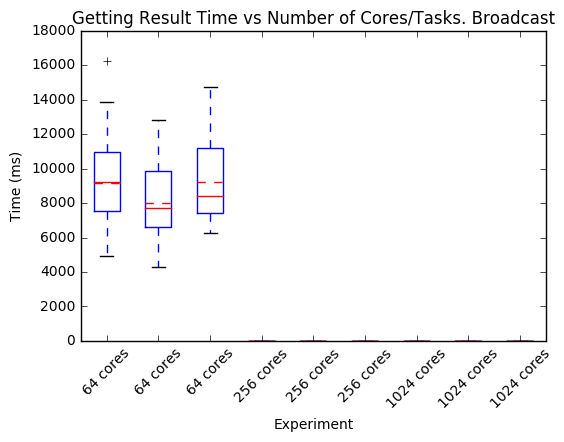

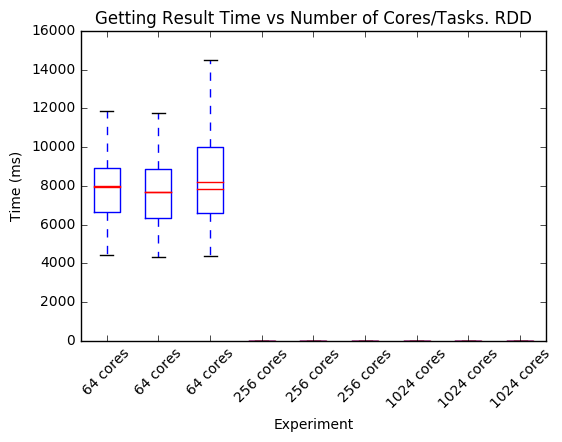

In [107]:
plt.figure()
meanlineprops = dict(linestyle='--')
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spBroad_app_64_1['GettingResultTime'],\
             spBroad_app_64_2['GettingResultTime'],\
             spBroad_app_64_3['GettingResultTime'],\
             spBroad_app_256_1['GettingResultTime'],\
             spBroad_app_256_2['GettingResultTime'],\
             spBroad_app_256_3['GettingResultTime'],\
             spBroad_app_1024_1['GettingResultTime'],\
             spBroad_app_1024_2['GettingResultTime'],\
             spBroad_app_1024_3['GettingResultTime']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Getting Result Time vs Number of Cores/Tasks. Broadcast')
plt.xticks(rotation=45)
plt.savefig('GettingResultTime_broadcast.png',dpi=800,bbox_inches='tight')
plt.savefig('GettingResultTime_broadcast.pdf',dpi=800,bbox_inches='tight')

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spsc_lf_app_64_1['GettingResultTime'],\
             spsc_lf_app_64_2['GettingResultTime'],\
             spsc_lf_app_64_3['GettingResultTime'],\
             spsc_lf_app_256_1['GettingResultTime'],\
             spsc_lf_app_256_2['GettingResultTime'],\
             spsc_lf_app_256_3['GettingResultTime'],\
             spsc_lf_app_1024_1['GettingResultTime'],\
             spsc_lf_app_1024_2['GettingResultTime'],\
             spsc_lf_app_1024_3['GettingResultTime']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Getting Result Time vs Number of Cores/Tasks. RDD')
plt.xticks(rotation=45)
plt.savefig('GettingResultTime_RDD.png',dpi=800,bbox_inches='tight')
plt.savefig('GettingResultTime_RDD.pdf',dpi=800,bbox_inches='tight')

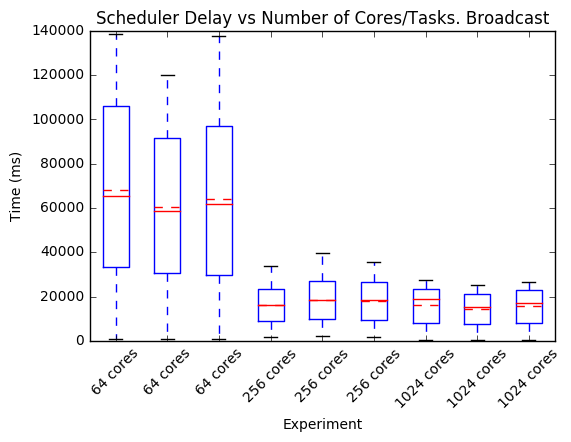

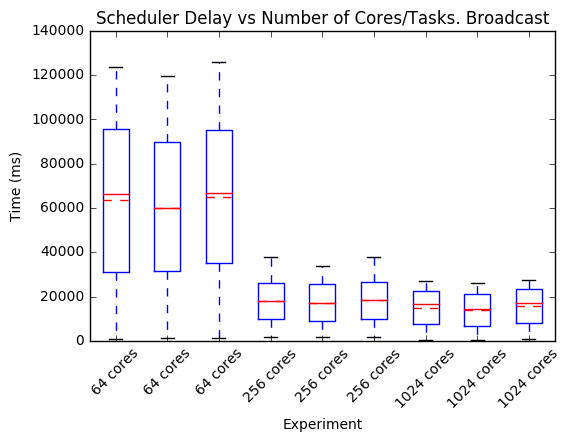

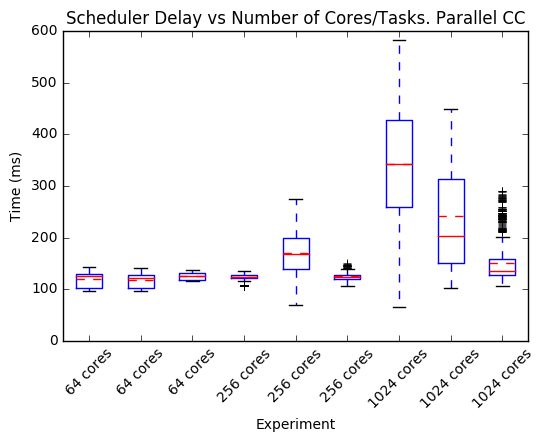

In [109]:
meanlineprops = dict(linestyle='--')
plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spBroad_app_64_1['SchedulerDelay'],\
             spBroad_app_64_2['SchedulerDelay'],\
             spBroad_app_64_3['SchedulerDelay'],\
             spBroad_app_256_1['SchedulerDelay'],\
             spBroad_app_256_2['SchedulerDelay'],\
             spBroad_app_256_3['SchedulerDelay'],\
             spBroad_app_1024_1['SchedulerDelay'],\
             spBroad_app_1024_2['SchedulerDelay'],\
             spBroad_app_1024_3['SchedulerDelay']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Scheduler Delay vs Number of Cores/Tasks. Broadcast')
plt.xticks(rotation=45)
plt.savefig('SchedulerDelay_broadcast.png',dpi=800,bbox_inches='tight')
plt.savefig('SchedulerDelay_broadcast.pdf',dpi=800,bbox_inches='tight')

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spsc_lf_app_64_1['SchedulerDelay'],\
             spsc_lf_app_64_2['SchedulerDelay'],\
             spsc_lf_app_64_3['SchedulerDelay'],\
             spsc_lf_app_256_1['SchedulerDelay'],\
             spsc_lf_app_256_2['SchedulerDelay'],\
             spsc_lf_app_256_3['SchedulerDelay'],\
             spsc_lf_app_1024_1['SchedulerDelay'],\
             spsc_lf_app_1024_2['SchedulerDelay'],\
             spsc_lf_app_1024_3['SchedulerDelay']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Scheduler Delay vs Number of Cores/Tasks. Broadcast')
plt.xticks(rotation=45)
plt.savefig('SchedulerDelay_rdd.png',dpi=800,bbox_inches='tight')
plt.savefig('SchedulerDelay_rdd.pdf',dpi=800,bbox_inches='tight')

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spParCC_lf_ParCC_app_64_1['SchedulerDelay'],\
             spParCC_lf_ParCC_app_64_2['SchedulerDelay'],\
             spParCC_lf_ParCC_app_64_3['SchedulerDelay'],\
             spParCC_lf_ParCC_app_256_1['SchedulerDelay'],\
             spParCC_lf_ParCC_app_256_2['SchedulerDelay'],\
             spParCC_lf_ParCC_app_256_3['SchedulerDelay'],\
             spParCC_lf_ParCC_app_1024_1['SchedulerDelay'],\
             spParCC_lf_ParCC_app_1024_2['SchedulerDelay'],\
             spParCC_lf_ParCC_app_1024_3['SchedulerDelay']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Scheduler Delay vs Number of Cores/Tasks. Parallel CC')
plt.xticks(rotation=45)
plt.savefig('SchedulerDelay_parallelcc.png',dpi=800,bbox_inches='tight')
plt.savefig('SchedulerDelay_parallelcc.pdf',dpi=800,bbox_inches='tight')

In [120]:
timings_64_1 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_2048_64_1/unit.000000/timings.npz.npy')
timings_64_2 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_2048_64_2/unit.000000/timings.npz.npy')
timings_64_3 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_2048_64_3/unit.000000/timings.npz.npy')
timings_256_1 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_512_256_1/unit.000000/timings.npz.npy')
timings_256_2 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_512_256_2/unit.000000/timings.npz.npy')
timings_256_3 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_512_256_3/unit.000000/timings.npz.npy')
timings_1024_1 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_128_1024_1/unit.000000/timings.npz.npy')
timings_1024_2 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_128_1024_2/unit.000000/timings.npz.npy')
timings_1024_3 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_128_1024_3/unit.000000/timings.npz.npy')

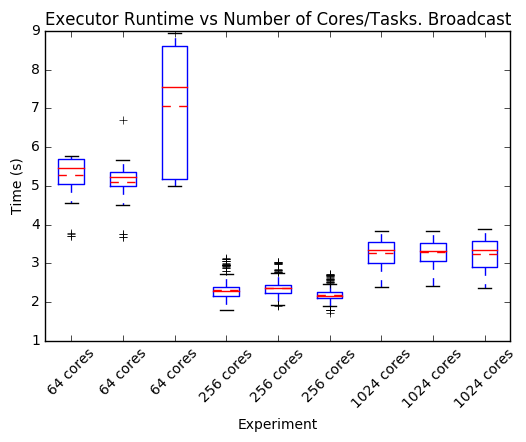

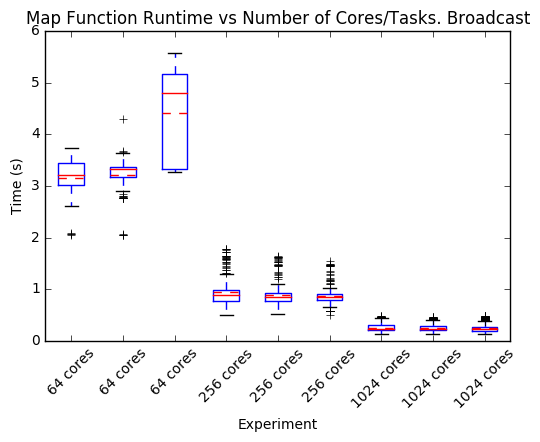

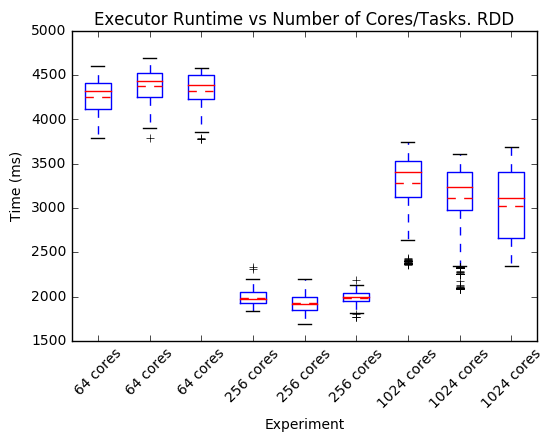

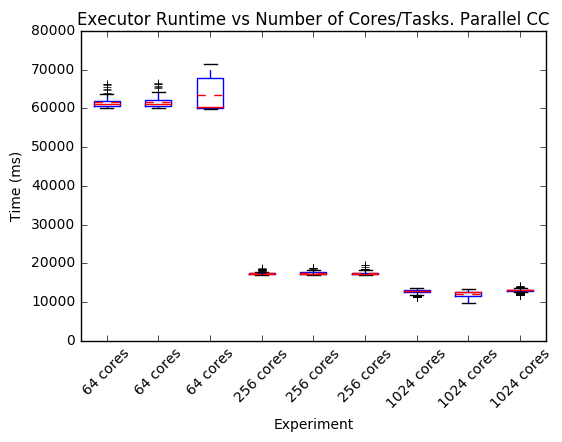

In [122]:
meanlineprops = dict(linestyle='--')
plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spBroad_app_64_1['Runtime']/1000,\
             spBroad_app_64_2['Runtime']/1000,\
             spBroad_app_64_3['Runtime']/1000,\
             spBroad_app_256_1['Runtime']/1000,\
             spBroad_app_256_2['Runtime']/1000,\
             spBroad_app_256_3['Runtime']/1000,\
             spBroad_app_1024_1['Runtime']/1000,\
             spBroad_app_1024_2['Runtime']/1000,\
             spBroad_app_1024_3['Runtime']/1000], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.title('Executor Runtime vs Number of Cores/Tasks. Broadcast')
plt.xticks(rotation=45)
plt.savefig('ExecutorRuntime_broadcast.png',dpi=800,bbox_inches='tight')
plt.savefig('ExecutorRuntime_broadcast.pdf',dpi=800,bbox_inches='tight')

plt.figure()
plt.boxplot([timings_64_1[:,1]-timings_64_1[:,0],\
             timings_64_2[:,1]-timings_64_2[:,0],\
             timings_64_3[:,1]-timings_64_3[:,0],\
             timings_256_1[:,1]-timings_256_1[:,0],\
             timings_256_2[:,1]-timings_256_2[:,0],\
             timings_256_3[:,1]-timings_256_3[:,0],\
             timings_1024_1[:,1]-timings_1024_1[:,0],\
             timings_1024_2[:,1]-timings_1024_2[:,0],\
             timings_1024_3[:,1]-timings_1024_3[:,0]], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.title('Map Function Runtime vs Number of Cores/Tasks. Broadcast')
plt.xticks(rotation=45)
plt.savefig('MapFunctionRuntime_broadcast.png',dpi=800,bbox_inches='tight')
plt.savefig('MapFunctionRuntime_broadcast.pdf',dpi=800,bbox_inches='tight')


plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spsc_lf_app_64_1['Runtime'],\
             spsc_lf_app_64_2['Runtime'],\
             spsc_lf_app_64_3['Runtime'],\
             spsc_lf_app_256_1['Runtime'],\
             spsc_lf_app_256_2['Runtime'],\
             spsc_lf_app_256_3['Runtime'],\
             spsc_lf_app_1024_1['Runtime'],\
             spsc_lf_app_1024_2['Runtime'],\
             spsc_lf_app_1024_3['Runtime']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Executor Runtime vs Number of Cores/Tasks. RDD')
plt.xticks(rotation=45)
plt.savefig('ExecutorRuntime_rdd.png',dpi=800,bbox_inches='tight')
plt.savefig('ExecutorRuntime_rdd.pdf',dpi=800,bbox_inches='tight')

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spParCC_lf_ParCC_app_64_1['Runtime'],\
             spParCC_lf_ParCC_app_64_2['Runtime'],\
             spParCC_lf_ParCC_app_64_3['Runtime'],\
             spParCC_lf_ParCC_app_256_1['Runtime'],\
             spParCC_lf_ParCC_app_256_2['Runtime'],\
             spParCC_lf_ParCC_app_256_3['Runtime'],\
             spParCC_lf_ParCC_app_1024_1['Runtime'],\
             spParCC_lf_ParCC_app_1024_2['Runtime'],\
             spParCC_lf_ParCC_app_1024_3['Runtime']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Executor Runtime vs Number of Cores/Tasks. Parallel CC')
plt.xticks(rotation=45)
plt.savefig('ExecutorRuntime_parallelcc.png',dpi=800,bbox_inches='tight')
plt.savefig('ExecutorRuntime_parallelcc.pdf',dpi=800,bbox_inches='tight')

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 9 Text xticklabel objects>)

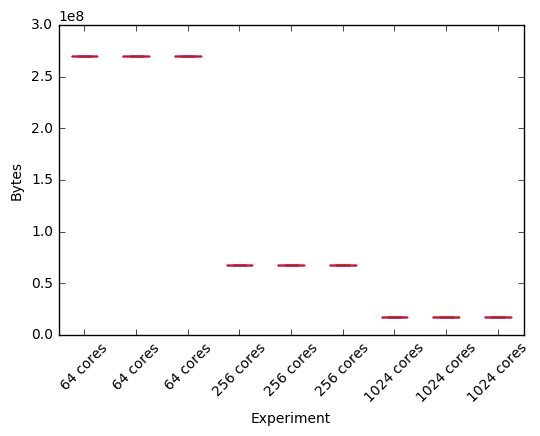

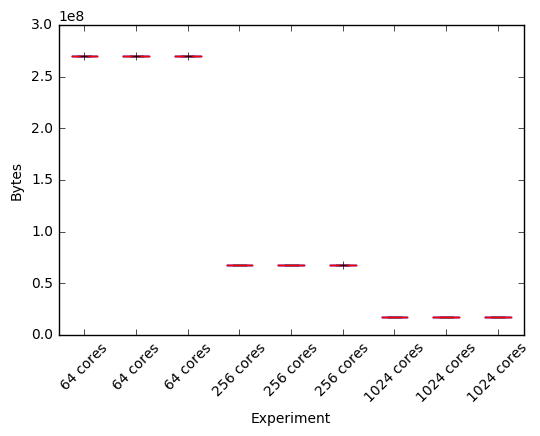

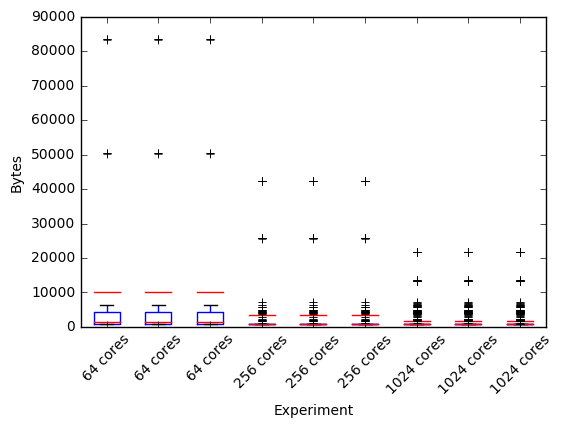

In [89]:
meanlineprops = dict(linestyle='--')
plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spBroad_app_64_1['ResultSize'],\
             spBroad_app_64_2['ResultSize'],\
             spBroad_app_64_3['ResultSize'],\
             spBroad_app_256_1['ResultSize'],\
             spBroad_app_256_2['ResultSize'],\
             spBroad_app_256_3['ResultSize'],\
             spBroad_app_1024_1['ResultSize'],\
             spBroad_app_1024_2['ResultSize'],\
             spBroad_app_1024_3['ResultSize']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Bytes')
plt.xticks(rotation=45)

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spsc_lf_app_64_1['ResultSize'],\
             spsc_lf_app_64_2['ResultSize'],\
             spsc_lf_app_64_3['ResultSize'],\
             spsc_lf_app_256_1['ResultSize'],\
             spsc_lf_app_256_2['ResultSize'],\
             spsc_lf_app_256_3['ResultSize'],\
             spsc_lf_app_1024_1['ResultSize'],\
             spsc_lf_app_1024_2['ResultSize'],\
             spsc_lf_app_1024_3['ResultSize']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Bytes')
plt.xticks(rotation=45)

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spParCC_lf_ParCC_app_64_1['ResultSize'],\
             spParCC_lf_ParCC_app_64_2['ResultSize'],\
             spParCC_lf_ParCC_app_64_3['ResultSize'],\
             spParCC_lf_ParCC_app_256_1['ResultSize'],\
             spParCC_lf_ParCC_app_256_2['ResultSize'],\
             spParCC_lf_ParCC_app_256_3['ResultSize'],\
             spParCC_lf_ParCC_app_1024_1['ResultSize'],\
             spParCC_lf_ParCC_app_1024_2['ResultSize'],\
             spParCC_lf_ParCC_app_1024_3['ResultSize']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Bytes')
plt.xticks(rotation=45)